# Index calculation: FSA-NPS DI, GPQI, HEI-2015(using receipts), HETI, HPI
All of the indices are calculated using receipt data, which was retrieved on 19th June, 2021.


Whole grains definition: belong to the grains & dietary fiber content >= 5g/100g products
Added sugar: estimated from the minor food categories and sugar content of products.

Saturated fat
Reducing saturated fat intake to less than 10% of total energy: , 1g fat => 9 Calories

Sugar  
Reducing sugar intake to less than 10% of total energy: a strong recommendation, 1g sugar => 4 Calories
https://www.who.int/mediacentre/news/releases/2015/sugar-guideline/en/


Participant exclusion criteria

1. start from participants who donated their receipts in loyalty cards
2. filter out participants who did not submit the FFQ 
3. rule out participants who did not finish the FFQ for at least 70%
4. rule out participants whose food on record cannot meet at least 1/7 of all card users' need
5. anomaly check

For receipts
1. Users should be in the list of eligible participants
2. Only the receipts within 28days before participants filling out the FFQ were considered.

Complete case analysis: Rows containing NaNs were excluded.




In [69]:
#standard settings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from scipy import stats,interp
from numpy import var
from scipy.stats.stats import pearsonr
from functools import reduce


In [70]:
# read files

FSA_NPS_data = pd.read_csv('Data/products_with_ofcom_value.csv', error_bad_lines=False)


#read files after applying filtering rules
demo_user = pd.read_csv('Data/demo_user.csv')
energy_filtered_data = pd.read_csv('Data/energy_filtered_data.csv')
daily_added_free_sugar_ffq = pd.read_csv('Data/daily_added_free_sugar_ffq.csv')
daily_sugar_purchase = pd.read_csv('Data/daily_sugar_purchase.csv')





b'Skipping line 2252: expected 33 fields, saw 37\nSkipping line 2253: expected 33 fields, saw 37\nSkipping line 6986: expected 33 fields, saw 37\nSkipping line 6987: expected 33 fields, saw 37\nSkipping line 6988: expected 33 fields, saw 35\nSkipping line 14479: expected 33 fields, saw 34\nSkipping line 15831: expected 33 fields, saw 37\n'
b'Skipping line 16529: expected 33 fields, saw 34\nSkipping line 16686: expected 33 fields, saw 34\nSkipping line 17838: expected 33 fields, saw 34\nSkipping line 20024: expected 33 fields, saw 34\nSkipping line 20252: expected 33 fields, saw 34\nSkipping line 23556: expected 33 fields, saw 34\nSkipping line 26672: expected 33 fields, saw 34\nSkipping line 26987: expected 33 fields, saw 34\nSkipping line 27028: expected 33 fields, saw 35\nSkipping line 27034: expected 33 fields, saw 34\nSkipping line 27058: expected 33 fields, saw 34\nSkipping line 28992: expected 33 fields, saw 35\nSkipping line 30741: expected 33 fields, saw 41\n'
b'Skipping line 3

# FSA-NPS DI calculation

FSA-NPS DI stands for Food Standards Agency Nutrient Profiling System Dietary Index

In [71]:
#select relevant columns for the FSA-NPS DI calculation
FSA_NPS_rel = FSA_NPS_data[['gtin','ofcom_value','nutri_score_calculated']]

#check the nan
FSA_NPS_rel.isna().sum()

gtin                          0
ofcom_value                7258
nutri_score_calculated    13187
dtype: int64

In [72]:
#enrich the receipts with information about the FSA-NPS DI details
receipts_rel = energy_filtered_data.merge(FSA_NPS_rel, how='left',on = 'gtin')
receipts_rel['ofcom_value'] = receipts_rel['ofcom_value'].astype('float')

#calculate the FSA-NPS DI
receipts_rel['energy*fsa_nps'] = (receipts_rel['actual_kcal'].values) * (receipts_rel['ofcom_value'].values)
numerator = receipts_rel.groupby('UserId')['energy*fsa_nps'].sum().reset_index()
denominator = receipts_rel.groupby('UserId')['actual_kcal'].sum().reset_index()
fsa_nps_di = numerator.merge(denominator, how='outer',on = 'UserId')
fsa_nps_di['fsa_nps_di'] = fsa_nps_di['energy*fsa_nps']/fsa_nps_di['actual_kcal']


# HEI-2015 from receipts

HEI-2015 stands for Healthy Eating Index-2015

Reference: Update of the Healthy Eating Index: HEI-2015
https://pubmed.ncbi.nlm.nih.gov/30146071/

In [73]:
# Create minor list of all receipts
minor_list = list(energy_filtered_data['minor'].unique())

# Create weight table  (only eligible participants)
weight = pd.DataFrame()
weight['UserId'] = energy_filtered_data['UserId'].unique().copy()
for minor in minor_list:
    weight[minor] = 0
    
# extra column for energy
weight['actual_kcal']=0

# calculate the weight of each food group
# as we are using relative share, the only thing matters is the length of the time window 
# household size doesn't matter here
for i in energy_filtered_data.index.values.tolist():            
        userId = energy_filtered_data['UserId'][i]
        minor = energy_filtered_data['minor'][i]
        quantity = energy_filtered_data['actual_quantity'][i]
        actual_kcal = energy_filtered_data['actual_kcal'][i]
        weight.loc[weight['UserId']==userId, minor] += quantity
        weight.loc[weight['UserId']==userId, 'actual_kcal'] += actual_kcal

In [74]:
#differentiate whole grains and refined grains
grain_list = ['Breads and rolls',
     'Crispbread, rusks, crackers and waffles',
     'Pasta',
     'Dough',
     'Rice',
     'Cornmeal and polenta',
     'Flakes and bran',
     'Muesli and cereals',
     'Other cereal products',
     'Flour and starch']

#16g of these grains corresponds to 1 cup equivalent
g16_ce_list = ['Breads and rolls','Crispbread, rusks, crackers and waffles']

#28.35g of these grains corresponds to 1 cup equivalent
g2835_ce_list = ['Pasta','Dough','Flour and starch','Rice' ,'Muesli and cereals','Other cereal products',
                 'Cornmeal and polenta', 'Flakes and bran']

is_grains = (energy_filtered_data['minor'].isin(grain_list))
is_whole = (energy_filtered_data['dietaryFiber']>=5)

# whole grain receipts  & refined grain receipts
whole_grain_receipts = energy_filtered_data[is_grains & is_whole]
refined_grain_receipts = energy_filtered_data[((is_grains == True) & (is_whole==False))]



In [75]:
# to get the name of a dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


#a function to generate the cup equivalent dataframe for grain-relevants things

def grain_ce(grain_df):
    # Create minor list for whole grains
    grain_minor_list = list(grain_df['minor'].unique())

    # Create weight table for whole grains
    grain_weight = pd.DataFrame(grain_df['UserId'].unique())
    grain_weight.columns = ['UserId']
    for minor in grain_minor_list:
        grain_weight[minor] = 0

    grain_weight['actual_kcal']=0

    # calculate the weight of each food group
    # as we are using relative share, the only thing matters is the length of the time window 
    # household size doesn't matter here
    for i in grain_df.index.values.tolist():            
            UserId = grain_df['UserId'][i]
            minor = grain_df['minor'][i]
            quantity = grain_df['actual_quantity'][i]
            actual_kcal = grain_df['actual_kcal'][i]
            grain_weight.loc[grain_weight['UserId'] == UserId, minor] += quantity
            grain_weight.loc[grain_weight['UserId'] == UserId, 'actual_kcal'] += actual_kcal
           
    grain_weight['16g'] = grain_weight[grain_weight.columns.intersection(g16_ce_list)].sum(axis=1)
    grain_weight['28.35g'] = grain_weight[grain_weight.columns.intersection(g2835_ce_list)].sum(axis=1)
    grain_weight[str(get_df_name(grain_df)) + '_ce'] = grain_weight['16g']/16 + grain_weight['28.35g']/28.35
            
    return grain_weight



In [76]:
#run the function for whole grain receipts and refined grain receipts
wg_weight = grain_ce(whole_grain_receipts)
rg_weight = grain_ce(refined_grain_receipts)

In [77]:
# create a dataframe for calculating HEI
HEI = pd.DataFrame()
HEI = weight[['UserId','actual_kcal']].copy()

In [78]:
# legumes are counted in four groups

# total fruits
HEI['total_fruits_250g'] = weight[['Fruit juices',
                                   'Cooked fruits (canned)']].sum(axis=1)
HEI['total_fruits_150g'] = weight[['Fresh fruits',
                                   'Frozen fruits']].sum(axis=1)
HEI['total_fruits_75g'] = weight['Dried fruits'] 
HEI['total_fruits_ce'] = HEI['total_fruits_250g']/250 + HEI['total_fruits_150g']/150 + HEI['total_fruits_75g']/75
HEI['total_fruits_ce/1000kcal'] = HEI['total_fruits_ce']*1000/HEI['actual_kcal']

# whole fruits
HEI['whole_fruits_150g'] = weight[['Fresh fruits',
                                   'Frozen fruits']].sum(axis=1)
HEI['whole_fruits_250g'] = weight['Cooked fruits (canned)']
HEI['whole_fruits_ce'] = HEI['whole_fruits_150g']/150 + HEI['whole_fruits_250g']/250
HEI['whole_fruits_ce/1000kcal'] = HEI['whole_fruits_ce']*1000/HEI['actual_kcal']

# total vegatables
#HEI['total_vegetables_60g'] = weight['Dried vegetables'].copy() #there is no dried vegetables
HEI['total_vegetables_70g'] = weight['Mushrooms']
HEI['total_vegetables_105g'] = weight['Sprouts and seedlings']
HEI['total_vegetables_120g'] = weight[['Fresh vegetables',
                                       'Frozen vegetables',
                                       'Herbs',
                                       'Salads',
                                       'Potatoes']].sum(axis=1)
HEI['total_vegetables_135g'] = weight['Olives']
HEI['total_vegetables_145g'] = weight['Avocado']
HEI['total_vegetables_150g'] = weight['Vegetables cooked (incl. cans)']
HEI['total_vegetables_175g'] = weight['Legumes'].copy()
#HEI['total_vegetables_245g'] = weight['Vegetable juices'] #no vegetable juices
HEI['total_vegetables_ce'] = HEI['total_vegetables_70g']/70 + HEI['total_vegetables_105g']/105 + \
                             HEI['total_vegetables_120g']/120 + HEI['total_vegetables_135g']/135 + \
                             HEI['total_vegetables_145g']/145+ HEI['total_vegetables_150g']/150 +\
                             HEI['total_vegetables_175g']/175 
HEI['total_vegetables_ce/1000kcal'] = HEI['total_vegetables_ce']*1000/HEI['actual_kcal']
                                              
# greens and beans
HEI['g&b_120g'] = weight[['Fresh vegetables',
                          'Frozen vegetables',
                          'Salads',
                         'Herbs']].sum(axis=1)
HEI['g&b_150g'] = weight['Vegetables cooked (incl. cans)'].copy()
HEI['g&b_175g'] = weight['Legumes']
HEI['g&b_ce'] = HEI['g&b_120g']/120 + HEI['g&b_150g']/150 + HEI['g&b_175g']/175
HEI['g&b_ce/1000kcal'] = HEI['g&b_ce']*1000/HEI['actual_kcal']


# dairy
HEI['dairy_42.525g'] = weight[['Cheese',
                              'Cheese products']].sum(axis=1)
HEI['dairy_127.575g'] = weight[['Cream cheese and cottage cheese',
                              'Soft cheese']].sum(axis=1)
HEI['dairy_245g'] = weight[['Yogurt and sour milk',
                           'Milk']].sum(axis=1)
HEI['dairy_ce'] = HEI['dairy_42.525g']/42.525 + HEI['dairy_127.575g']/127.575 + HEI['dairy_245g']/245
HEI['dairy_ce/1000kcal'] = HEI['dairy_ce']*1000/HEI['actual_kcal']

# total protein foods
HEI['protein_foods_14.175g'] = weight[['Seeds, kernels, nuts']]
HEI['protein_foods_28.35g'] = weight[['Fish products',
                                      'Marine fish',
                                      'Seafood, crustaceans and shellfish',
                                      #'Freshwater fish',#(none was bought)
                                      'Poultry',
                                      'Veal',
                                      'Lamb & sheep',
                                      'Beef',
                                      'Pork',
                                      #'Other types of meat', #(none was bought)
                                      #'Venison'#,(no venison was bought)
                                      ]].sum(axis=1)
HEI['protein_foods_50g'] = weight['Eggs']
HEI['protein_foods_43.75g'] = weight['Legumes']
HEI['protein_foods_62.5g'] = weight[['Tofu','Vegetarian meat alternatives']].sum(axis=1) #'Quorn',none was bought
HEI['protein_foods_ce'] = HEI['protein_foods_14.175g']/14.175 + HEI['protein_foods_28.35g']/28.35+ HEI['protein_foods_50g']/50 + HEI['protein_foods_43.75g']/43.75+ HEI['protein_foods_62.5g']/62.5
HEI['protein_foods_ce/1000kcal'] = HEI['protein_foods_ce']*1000/HEI['actual_kcal']

# Seafood and plant proteins
HEI['seafood_plant_14.175g'] = weight[['Seeds, kernels, nuts']]
HEI['seafood_plant_28.35g'] = weight[['Fish products',
                                      'Marine fish',
                                      'Seafood, crustaceans and shellfish']].sum(axis=1) # no 'Freshwater fish'
HEI['seafood_plant_43.75g'] = weight['Legumes']
HEI['seafood_plant_62.5g'] = weight[['Tofu','Vegetarian meat alternatives']].sum(axis=1) #'Quorn',
HEI['seafood_plant_ce'] = HEI['seafood_plant_14.175g']/14.175 + HEI['seafood_plant_28.35g']/28.35 + HEI['seafood_plant_43.75g']/43.75 + HEI['seafood_plant_62.5g']/62.5
HEI['seafood_plant_ce/1000kcal'] = HEI['seafood_plant_ce']*1000/HEI['actual_kcal']




In [79]:
HEI_rel = HEI[['UserId','total_fruits_ce/1000kcal','whole_fruits_ce/1000kcal',
             'total_vegetables_ce/1000kcal','g&b_ce/1000kcal','dairy_ce/1000kcal','protein_foods_ce/1000kcal',
             'seafood_plant_ce/1000kcal','actual_kcal']]

In [80]:
HEI_rel = HEI_rel.merge(wg_weight[['UserId','whole_grain_receipts_ce']], how='outer',on = 'UserId')
HEI_rel = HEI_rel.merge(rg_weight[['UserId','refined_grain_receipts_ce']], how='outer',on = 'UserId')
HEI_rel['whole_grains_ce/1000kcal'] = HEI_rel['whole_grain_receipts_ce']*1000/HEI_rel['actual_kcal']
HEI_rel['refined_grains_ce/1000kcal'] = HEI_rel['refined_grain_receipts_ce']*1000/HEI_rel['actual_kcal']
# fill in na, assume the nan is 0/ the median level 
# when it is missing, it is more likely not to be whole grains
HEI_rel['whole_grains_ce/1000kcal'] = HEI_rel['whole_grains_ce/1000kcal'].fillna(0)
HEI_rel['refined_grains_ce/1000kcal'] = HEI_rel['refined_grains_ce/1000kcal'].fillna(0)

In [81]:
#get the saturated fat, fat, sodium, sugar purchase of different users
saturated_fat = energy_filtered_data.groupby('UserId')['saturatedFat_actual_quantity'].sum().reset_index()

total_fat = energy_filtered_data.groupby('UserId')['totalFat_actual_quantity'].sum().reset_index()

sodium = energy_filtered_data.groupby('UserId')['sodium_actual_quantity'].sum().reset_index()

sugar = energy_filtered_data.groupby('UserId')['sugars_actual_quantity'].sum().reset_index()


nutrient_list = [saturated_fat,total_fat,sodium,sugar]
merged_nutrients = reduce(lambda  left,right: pd.merge(left,right,on=['UserId'],
                                            how='outer'), nutrient_list)
HEI_rel = HEI_rel.merge(merged_nutrients, how='outer',on = 'UserId')


HEI_rel['unsat_sat_fat_ratio'] = (HEI_rel['totalFat_actual_quantity']-HEI_rel['saturatedFat_actual_quantity'])/HEI_rel['saturatedFat_actual_quantity']

In [82]:
# 1g sugar is of 4 calories, 1g fat is of 9 calories
HEI_rel['sodium_g/1000kcal'] = HEI_rel['sodium_actual_quantity']*1000/HEI_rel['actual_kcal']
HEI_rel['sat_fat_energy_contri'] = HEI_rel['saturatedFat_actual_quantity']*9/(1000*HEI_rel['actual_kcal'])
HEI_rel['sugar_energy_contri'] = HEI_rel['sugars_actual_quantity']*4/(1000*HEI_rel['actual_kcal'])
                                                             

In [83]:
# calculate the scores for them
HEI_rel['total_fruits_score'] = (6.25*HEI_rel['total_fruits_ce/1000kcal']).clip(upper = 5)
HEI_rel['whole_fruits_score'] = (12.5*HEI_rel['whole_fruits_ce/1000kcal']).clip(upper = 5)
HEI_rel['total_vegetables_score'] = (4.545*HEI_rel['total_vegetables_ce/1000kcal']).clip(upper = 5)
HEI_rel['greens and beans'] = (25*HEI_rel['g&b_ce/1000kcal']).clip(upper = 5)
HEI_rel['whole_grains_score'] = (6.667*HEI_rel['whole_grains_ce/1000kcal']).clip(upper = 10)
HEI_rel['dairy_score'] = (7.692*HEI_rel['dairy_ce/1000kcal']).clip(upper = 10)
HEI_rel['total_protein_score'] = (2*HEI_rel['protein_foods_ce/1000kcal']).clip(upper = 5)
HEI_rel['seafood_plant_score'] = (6.25*HEI_rel['seafood_plant_ce/1000kcal']).clip(upper = 5)
HEI_rel['fatty_acids_score'] = (7.692*HEI_rel['unsat_sat_fat_ratio']-9.230).clip(lower=0,upper = 10)
HEI_rel['refined_grains_score'] = (-4*HEI_rel['refined_grains_ce/1000kcal']+17.2).clip(lower=0,upper = 10)
HEI_rel['sodium_score'] = (-11.111*HEI_rel['sodium_g/1000kcal']+22.222).clip(lower=0,upper = 10)
HEI_rel['sugars_score'] = (-51.282*HEI_rel['sugar_energy_contri']+13.333).clip(lower=0,upper = 10)
HEI_rel['saturated_fat_score'] = (-125*HEI_rel['sat_fat_energy_contri']+20).clip(lower=0,upper = 10)
HEI_rel['HEI_from_receipts'] = HEI_rel[['total_fruits_score', 'whole_fruits_score', 'total_vegetables_score','greens and beans', 
                                    'whole_grains_score', 'dairy_score','total_protein_score', 'seafood_plant_score', 
                                    'fatty_acids_score','refined_grains_score', 'sodium_score', 'sugars_score',
                                    'saturated_fat_score']].sum(axis=1)


In [84]:
HEI_rel.iloc[:,21:35].describe()

total_fruits_score  whole_fruits_score  total_vegetables_score  \
count           89.000000           89.000000               89.000000   
mean             3.767953            4.221839                4.224490   
std              1.584134            1.464966                1.315206   
min              0.000000            0.000000                0.000000   
25%              2.866144            4.112515                3.748962   
50%              4.538419            5.000000                5.000000   
75%              5.000000            5.000000                5.000000   
max              5.000000            5.000000                5.000000   

       greens and beans  whole_grains_score  dairy_score  total_protein_score  \
count         89.000000           89.000000    89.000000            89.000000   
mean           4.850419            3.728631     6.546140             2.073123   
std            0.801331            4.055182     3.235917             1.604257   
min            0.000000            0.000000     0.000000             0.000000   
25%            5.000000            0.000000     3.853348             0.836641   
50%            5.000000            2.290997     6.971469             1.805805   
75%            5.000000            7.551288    10.000000             3.037242   
max            5.000000           10.000000    10.000000             5.000000   

       seafood_plant_score  fatty_acids_score  refined_grains_score  \
count            89.000000          89.000000             89.000000   
mean              1.869024           2.206242              4.839742   
std               2.046497           2.938935              4.074207   
min               0.000000           0.000000              0.000000   
25%               0.000000           0.000000              0.000000   
50%               0.702675           0.989367              4.302140   
75%               3.872419           3.629461              9.650975   
max               5.000000          10.000000             10.000000   

       sodium_score  sugars_score  saturated_fat_score  HEI_from_receipts  
count     89.000000          89.0                 89.0          89.000000  
mean       8.422526          10.0                 10.0          66.750130  
std        2.653651           0.0                  0.0          10.455259  
min        0.000000          10.0                 10.0          41.334394  
25%        7.362490          10.0                 10.0          59.350296  
50%       10.000000          10.0                 10.0          67.440153  
75%       10.000000          10.0                 10.0          74.094988  
max       10.000000          10.0                 10.0          90.731599

Mean HEI from receipts: 66.75
Median HEI from receipts: 67.44


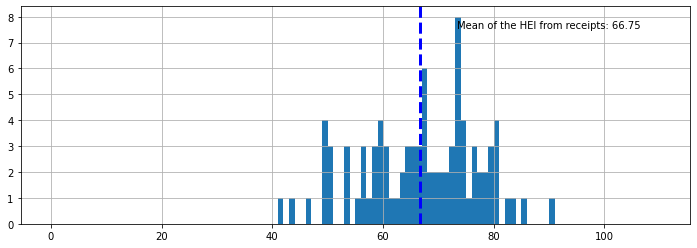

In [85]:
print("Mean HEI from receipts: " + str(round(HEI_rel['HEI_from_receipts'].mean(),2)))
print("Median HEI from receipts: " + str(round(HEI_rel['HEI_from_receipts'].median(),2)))
HEI_rel['HEI_from_receipts'].hist(bins=110, range=[0,110], figsize=(12,4));
plt.axvline(HEI_rel['HEI_from_receipts'].mean(), color='blue', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(HEI_rel['HEI_from_receipts'].mean()*1.1, max_ylim*0.9, 'Mean of the HEI from receipts: {:.2f}'.format(HEI_rel['HEI_from_receipts'].mean()), color = 'black');

# Healthy Trolley Index (HETI)

Reference: Feasibility of a Healthy Trolley Index to assess dietary quality of the householdfood supply
https://www.cambridge.org/core/journals/british-journal-of-nutrition/article/feasibility-of-a-healthy-trolley-index-to-assess-dietary-quality-of-the-household-food-supply/F66BDB5386C53BFDD0D27870BA463751

An expenditure-based shopping index
Here, we follow the original definition

In [86]:
# use the same minor_list as for HEI in receipts

expense = pd.DataFrame(energy_filtered_data['UserId'].unique())
expense.columns = ['UserId']
for minor in minor_list:
    expense[minor] = 0 
    
    
# energy based HETI
energy_kcal = pd.DataFrame(energy_filtered_data['UserId'].unique())
energy_kcal.columns = ['UserId']
for minor in minor_list:
    energy_kcal[minor] = 0         
        

# quantity based HETI
quantity = pd.DataFrame(energy_filtered_data['UserId'].unique())
quantity.columns = ['UserId']
for minor in minor_list:
    quantity[minor] = 0    
    
    
# calculate the expense of each food group
# as we are using relative share, the only thing matters is the length of the time window 
# household size doesn't matter here
for i in energy_filtered_data.index.values.tolist():            
        userId = energy_filtered_data['UserId'][i]
        minor = energy_filtered_data['minor'][i]
        price = energy_filtered_data['real_price'][i]
        expense.loc[expense['UserId']==userId, minor] += price
        
        energy = energy_filtered_data['actual_kcal'][i]
        energy_kcal.loc[energy_kcal['UserId']==userId, minor] += energy

        quantity_product = energy_filtered_data['actual_quantity'][i]
        quantity.loc[quantity['UserId']==userId, minor] += quantity_product
        


In [87]:
total_expense = pd.DataFrame()
total_expense['UserId'] = expense['UserId'].copy()
total_expense['grains&cereals'] = expense[['Breads and rolls','Dough','Pasta','Crispbread, rusks, crackers and waffles',
                                           'Flour and starch','Muesli and cereals','Other cereal products','Rice',]].sum(axis = 1)
total_expense['meat&alterenatives'] = expense[['Beef','Poultry','Veal','Vegetarian meat alternatives','Seeds, kernels, nuts',
                                              'Pork','Fish products','Marine fish','Lamb & sheep',#'Freshwater fish',
                                              'Seafood, crustaceans and shellfish','Tofu',]].sum(axis = 1) 
total_expense['dairy&alternatives'] = expense[['Cheese','Milk','Milk and yoghurt drinks','Cheese products',
                                               'Yogurt and sour milk','Cream cheese and cottage cheese','Soft cheese',]].sum(axis = 1)
total_expense['fruits'] = expense[['Fresh fruits','Dried fruits','Cooked fruits (canned)','Frozen fruits',]].sum(axis = 1)
total_expense['vegetables'] = expense[['Fresh vegetables','Potatoes','Vegetables cooked (incl. cans)','Herbs','Mushrooms',
                                       'Salads','Frozen vegetables','Frozen vegetables','Avocado','Legumes','Sprouts and seedlings',]].sum(axis = 1)
total_expense['discretionary'] = expense[['Meat sliced','Chocolate and cocoa products','Creams and puddings','Crisps','Sausage',
                                          'Cream','Soft drinks minor','Sweet baked goods','Sweet drinks energy-reduced',
                                          'Cake and pies','Salad dressings','Bars','Sauces','Milk-based ice cream','Spreads',
                                          'Sugar and sweeteners','Mayonnaise','Olives','Cookies','Other salty snacks',
                                          'Puff pastry','Savory pies and gratins','Salt sticks','Jams and sweet spreads',
                                          'Miscellaneous sweets','Syrup','Asian dishes']].sum(axis = 1) #,'Misc. beverages','Fast food'
# sum up all cost to get the final cost
total_expense['sum'] = expense.iloc[:,1:].sum(axis=1)
expense_share = total_expense[['grains&cereals', 'meat&alterenatives', 'dairy&alternatives', 'fruits',
       'vegetables', 'discretionary']].add_suffix('%').div(total_expense['sum'], axis=0)*100
total_expense = pd.concat([total_expense,expense_share],axis=1)


In [88]:
# calculate the score
upper_disc = total_expense['discretionary%'].quantile(0.75)
total_expense['grain_score'] = (0.357*total_expense['grains&cereals%']).clip(upper = 10)
total_expense['meat_score'] = (0.769*total_expense['meat&alterenatives%']).clip(upper = 10)
total_expense['dairy_score'] = (0.833*total_expense['dairy&alternatives%']).clip(upper = 10)
total_expense['fruit_score'] = (1.111*total_expense['fruits%']).clip(upper = 10)
total_expense['vegetable_score'] = (0.385*total_expense['vegetables%']).clip(upper = 10)
total_expense['discretionary_score'] = (10/(upper_disc-12)*(upper_disc-total_expense['discretionary%'])).clip(lower=0,upper = 10)
# sum all and convert the max from 60 to 100
total_expense.loc[:,'HETI'] = total_expense.iloc[:,14:20].sum(axis=1)*5/3


In [89]:
total_expense.iloc[:,14:21].describe()

grain_score  meat_score  dairy_score  fruit_score  vegetable_score  \
count    89.000000   89.000000    89.000000    89.000000        89.000000   
mean      4.036008    5.379344     8.423117     7.605613         6.963818   
std       2.211417    4.100819     2.843485     3.140801         2.953613   
min       0.000000    0.000000     0.000000     0.000000         0.000000   
25%       2.407725    0.428708     7.279702     5.298922         4.734607   
50%       3.646617    6.085717    10.000000     9.840545         7.423727   
75%       5.574641   10.000000    10.000000    10.000000        10.000000   
max      10.000000   10.000000    10.000000    10.000000        10.000000   

       discretionary_score       HETI  
count            89.000000  89.000000  
mean              4.726330  61.890382  
std               4.021349  15.257561  
min               0.000000  23.449139  
25%               0.000000  55.117304  
50%               3.855648  63.527741  
75%               9.397864  70.957034  
max              10.000000  91.591865

Mean HETI (from receipts): 61.89
Median HETI (from receipts): 63.53


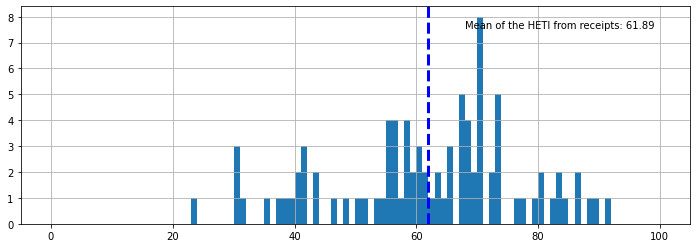

In [90]:
print("Mean HETI (from receipts): " + str(round(total_expense['HETI'].mean(),2)))
print("Median HETI (from receipts): " + str(round(total_expense['HETI'].median(),2)))
total_expense['HETI'].hist(bins=100, range=[0,100], figsize=(12,4));
plt.axvline(total_expense['HETI'].mean(), color='blue', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(total_expense['HETI'].mean()*1.1, max_ylim*0.9, 'Mean of the HETI from receipts: {:.2f}'.format(total_expense['HETI'].mean()), color = 'black');

In [91]:
HETI_details = total_expense[['UserId', 'grains&cereals%', 'meat&alterenatives%','dairy&alternatives%', 'fruits%', 
                              'vegetables%', 'discretionary%','HETI']]


# Healthy Purchase Index (HPI)

An expenditure-based shopping index

Reference: Development of the Healthy Purchase Index (HPI): a scoring system to assess the nutritional quality of household food purchases
https://www.cambridge.org/core/journals/public-health-nutrition/article/development-of-the-healthy-purchase-index-hpi-a-scoring-system-to-assess-the-nutritional-quality-of-household-food-purchases/DF18E2AFAA6D7D7832607D6E7F8DE4CC


In [92]:
#create a dataframe for HPI calculation
hpi_expense = pd.DataFrame()
hpi_expense.loc[:,'UserId'] = expense.loc[:,'UserId'].copy()

In [94]:
#get the expense of refined grains
expense_refined_grains = refined_grain_receipts.groupby('UserId')['real_price'].sum().reset_index()
expense_refined_grains = expense_refined_grains.rename(columns = {'real_price':'refined_grains'})

In [95]:
#get the total expense 
expense_total = energy_filtered_data.groupby('UserId')['real_price'].sum().reset_index()
expense_total = expense_total.rename(columns = {'real_price':'total_expense'})

In [96]:
#get the expense of different HPI sub-categories
hpi_expense['fruit'] = expense[['Fresh fruits','Dried fruits','Cooked fruits (canned)','Frozen fruits','Avocado', 'Seeds, kernels, nuts']].sum(axis = 1)
hpi_expense['vegetables'] = expense[['Fresh vegetables','Vegetables cooked (incl. cans)','Herbs','Mushrooms',
                                       'Salads','Frozen vegetables','Frozen vegetables','Sprouts and seedlings']].sum(axis = 1)
hpi_expense['starches'] = expense[['Breads and rolls','Dough','Pasta','Crispbread, rusks, crackers and waffles', #'Flakes and bran',
                                    'Cornmeal and polenta','Flour and starch','Muesli and cereals','Other cereal products','Rice',
                                    'Potatoes','Legumes']].sum(axis = 1)
hpi_expense['meat_fish_eggs'] = expense[['Beef','Poultry','Veal','Pork','Fish products',
                             'Marine fish','Lamb & sheep','Seafood, crustaceans and shellfish','Eggs']].sum(axis = 1) #'Freshwater fish',
hpi_expense['dairy'] = expense[['Cheese','Milk','Milk and yoghurt drinks','Cheese products',
                                               'Yogurt and sour milk','Cream cheese and cottage cheese','Soft cheese']].sum(axis = 1)
hpi_expense['fruit_vegi'] = hpi_expense.loc[:,'fruit'] + hpi_expense.loc[:,'vegetables']
hpi_expense['added_fat_seasonings'] = expense[['Fats', 'Salad dressings','Mayonnaise','Sauces', 'Spreads','Oils',
                                               'Cream','Butter and margarine']].sum(axis = 1)
hpi_expense['sweet_snacks'] = expense[['Chocolate and cocoa products','Creams and puddings',
                                          'Cream','Bars','Milk-based ice cream','Water-based ice',
                                          'Sugar and sweeteners','Jams and sweet spreads',
                                          'Miscellaneous sweets','Cookies','Puff pastry',
                                       'Savory pies and gratins','Cake and pies','Sweet baked goods',
                                      'Sweets, fruit and chewing gum']].sum(axis = 1) 
hpi_expense['cheese'] = expense[['Cheese','Cheese products','Cream cheese and cottage cheese','Soft cheese']].sum(axis = 1)
hpi_expense['sugary_drinks'] = expense[['Syrup', 'Soft drinks minor', 'Sweet drinks energy-reduced','Fruit juices']].sum(axis = 1)
hpi_expense['fish'] = expense[['Fish products','Marine fish','Seafood, crustaceans and shellfish']].sum(axis = 1)


In [97]:
#enrich the hpi_expense dataframe with refined grain expense and total expense
hpi_expense = hpi_expense.merge(expense_refined_grains, on = 'UserId', how = 'outer')
hpi_expense = hpi_expense.merge(expense_total, on = 'UserId', how = 'outer')

In [98]:
#calculate the expense percentage of different categories
total_expense_col_num = hpi_expense.shape[1]
for i in range(1,total_expense_col_num-1):
    hpi_expense[hpi_expense.columns[i]+'%'] = hpi_expense.iloc[:,i]/hpi_expense.iloc[:,(total_expense_col_num-1)]

In [99]:
#initialize all scores with 0
hpi_expense[['fruit_score', 'vegetables_score', 'starches_score', 'meat_fish_egg_score', 
             'dairy_score', 'fruit_vegi_score', 'added_fat_seasoning_score', 'sweet_snacks_score',
            'cheese_score', 'sugary_drinks_score', 'refined_grains_score', 'fish_score']] = 0

In [100]:
#calculate the vegi fat of different users
is_vegi = energy_filtered_data['major'] == 'Vegetables'
vegi_receipts = energy_filtered_data[is_vegi]
vegi_fat = vegi_receipts.groupby(['UserId'])['totalFat_actual_quantity'].sum().reset_index()
#rename column 
vegi_fat = vegi_fat.rename(columns = {'totalFat_actual_quantity':'total_vegi_fat'})

#enrich the hpi_expense dataframe with vegi fat content 
hpi_expense = hpi_expense.merge(vegi_fat, on = 'UserId', how = 'outer')


In [101]:
#assign scores to different categories
for i in range(hpi_expense.shape[0]):
    if hpi_expense.loc[i,'fruit%'] >= 0.05:
        hpi_expense.loc[i,'fruit_score'] = 1
    if hpi_expense.loc[i,'vegetables%'] >= 0.05:
        hpi_expense.loc[i,'vegetables_score'] = 1
    if hpi_expense.loc[i,'starches%'] >= 0.05:
        hpi_expense.loc[i,'starches_score'] = 1
    if hpi_expense.loc[i,'meat_fish_eggs%'] >= 0.05:
        hpi_expense.loc[i,'meat_fish_egg_score'] = 1
    if hpi_expense.loc[i,'dairy%'] >= 0.05:
        hpi_expense.loc[i,'dairy_score'] = 1
    if hpi_expense.loc[i,'fruit_vegi%'] >= 0.15:
        hpi_expense.loc[i,'fruit_vegi_score'] = 1
    if hpi_expense.loc[i,'fruit_vegi%'] >= 0.25:
        hpi_expense.loc[i,'fruit_vegi_score'] = 2
    if (hpi_expense.loc[i,'added_fat_seasonings%'] < 0.03) and (hpi_expense.loc[i,'total_vegi_fat'] > 0):
        hpi_expense.loc[i,'added_fat_seasoning_score'] = 1
    if hpi_expense.loc[i,'sweet_snacks%'] < 0.1:
        hpi_expense.loc[i,'sweet_snacks_score'] = 1
    if hpi_expense.loc[i,'sweet_snacks%'] < 0.05:
        hpi_expense.loc[i,'sweet_snacks_score'] = 2
    if hpi_expense.loc[i,'cheese%'] < 0.05:
        hpi_expense.loc[i,'cheese_score'] = 1
    if hpi_expense.loc[i,'sugary_drinks%'] < 0.03:
        hpi_expense.loc[i,'sugary_drinks_score'] = 1
    if hpi_expense.loc[i,'refined_grains%']/hpi_expense.loc[i,'starches%'] < 0.5:
        hpi_expense.loc[i,'refined_grains_score'] = 1
    if hpi_expense.loc[i,'fish%'] >= 0.05:
        hpi_expense.loc[i,'fish_score'] = 1
    if hpi_expense.loc[i,'fish%'] >= 0.1:
        hpi_expense.loc[i,'fish_score'] = 2
        

In [102]:
#sum up all scores
hpi_expense['hpi_diversity'] = hpi_expense[['fruit_score', 'vegetables_score', 'starches_score', 'meat_fish_egg_score', 
             'dairy_score']].sum(axis = 1)
hpi_expense['hpi_quality'] = hpi_expense[['fruit_vegi_score', 'added_fat_seasoning_score', 'sweet_snacks_score',
            'cheese_score', 'sugary_drinks_score', 'refined_grains_score', 'fish_score']].sum(axis = 1)
hpi_expense['hpi'] = hpi_expense[['hpi_diversity', 'hpi_quality']].sum(axis = 1)


In [103]:
hpi_expense['hpi'].describe()

count    89.000000
mean      8.337079
std       2.250979
min       4.000000
25%       7.000000
50%       8.000000
75%      10.000000
max      13.000000
Name: hpi, dtype: float64

# Grocery Purchase Quality Index-2016 (GPQI)

Reference: The Grocery Purchase Quality Index-2016: An innovative approach toassessing grocery food purchases

https://www.sciencedirect.com/science/article/pii/S0889157517301667?casa_token=EIqcKEryWGQAAAAA:fkD0QV8UTQGKNqfkvrb38vTkVoR5pA8-FClFlsJcUI-WhwSEm9tW0nKK2nX5wnaQgkxtVB4ZKzux

In [104]:
# aggregate receipts of refined grains

GPQI_expense = pd.DataFrame()
GPQI_expense['UserId'] = expense['UserId'].copy()
GPQI_expense['total_protein'] = expense[['Beef','Poultry','Veal','Seeds, kernels, nuts',
                                              'Pork','Fish products','Marine fish','Lamb & sheep',
                                              'Seafood, crustaceans and shellfish','Eggs']].sum(axis = 1) 
                                      #'Other types of meat', #(none was bought)
                                      #'Venison'#,(no venison was bought)
                                    #'Freshwater fish',
GPQI_expense['seafood&nuts'] = expense[['Fish products','Marine fish','Seafood, crustaceans and shellfish',
                                        'Seeds, kernels, nuts']].sum(axis = 1) #'Freshwater fish',
GPQI_expense['processed_meat'] = expense[['Sausage','Meat sliced']].sum(axis = 1)                          
GPQI_expense['dairy'] = expense[['Cheese','Milk','Milk and yoghurt drinks','Cheese products',
                                               'Yogurt and sour milk','Cream cheese and cottage cheese','Soft cheese']].sum(axis = 1)
GPQI_expense['total_fruits'] = expense[['Fruit juices','Fresh fruits','Dried fruits','Cooked fruits (canned)','Frozen fruits',]].sum(axis = 1)
GPQI_expense['whole_fruits'] = expense[['Fresh fruits','Cooked fruits (canned)','Frozen fruits']].sum(axis = 1)
GPQI_expense['total_vegetables'] = expense[['Fresh vegetables','Potatoes','Vegetables cooked (incl. cans)','Herbs','Mushrooms',
                                       'Salads','Frozen vegetables','Frozen vegetables','Legumes','Sprouts and seedlings',
                                           'Tofu','Vegetarian meat alternatives','Avocado']].sum(axis = 1)
                                        #'Vegetable juices', 'Quorn'
GPQI_expense['greens&beans'] = expense[['Fresh vegetables','Vegetables cooked (incl. cans)','Herbs',
                                       'Salads','Frozen vegetables','Legumes','Tofu',#'Quorn',
                                        'Vegetarian meat alternatives']].sum(axis = 1)

GPQI_expense['sweets&sodas'] = expense[['Chocolate and cocoa products','Creams and puddings',
                                          'Cream','Soft drinks minor','Sweet drinks energy-reduced',
                                          'Salad dressings','Bars','Sauces','Milk-based ice cream','Spreads',
                                          'Sugar and sweeteners','Mayonnaise','Olives','Other salty snacks',
                                          'Jams and sweet spreads',
                                          'Miscellaneous sweets','Syrup']].sum(axis = 1) #,'Misc. beverages'
# calculate the expense on refined and whole grains
GPQI_refined_expense = refined_grain_receipts.groupby('UserId')['real_price'].sum().reset_index()
GPQI_refined_expense = GPQI_refined_expense.rename(columns = {'real_price':'rg_expense'})
GPQI_whole_expense = whole_grain_receipts.groupby('UserId')['real_price'].sum().reset_index()
GPQI_whole_expense = GPQI_whole_expense.rename(columns = {'real_price':'wg_expense'})
# merge data
GPQI_expense = GPQI_expense.merge(GPQI_refined_expense,on='UserId',how = 'outer')
GPQI_expense = GPQI_expense.merge(GPQI_whole_expense,on='UserId',how = 'outer')
# fill nan in whole/refined grains with 0
GPQI_expense = GPQI_expense.fillna(0)
GPQI_expense['sum'] = GPQI_expense.iloc[:,1:].sum(axis=1)
GPQI_expense_share = GPQI_expense.iloc[:,1:12].add_suffix('%').div(GPQI_expense['sum'], axis=0)*100
GPQI_expense = pd.concat([GPQI_expense,GPQI_expense_share],axis=1)

In [105]:
# calculate the score

GPQI_expense['total_fruit_score'] = (0.289*GPQI_expense['total_fruits%']).clip(upper = 5)
GPQI_expense['whole_fruit_score'] = (0.336*GPQI_expense['whole_fruits%']).clip(upper = 5)
GPQI_expense['total_vegetable_score'] = (0.195*GPQI_expense['total_vegetables%']).clip(upper = 5)
GPQI_expense['greens&beans_score'] = (0.427*GPQI_expense['greens&beans%']).clip(upper = 5)
GPQI_expense['whole_grains_score'] = (0.917*GPQI_expense['wg_expense%']).clip(upper = 10)
GPQI_expense['dairy_score'] = (0.730*GPQI_expense['dairy%']).clip(upper = 10)
GPQI_expense['total_protein_score'] = (0.244*GPQI_expense['total_protein%']).clip(upper = 5)
GPQI_expense['seafood&nuts_score'] = (0.543*GPQI_expense['seafood&nuts%']).clip(upper = 5)
GPQI_expense['refined_grains_score'] = 0
for i in range(len(GPQI_expense['rg_expense%'])):
    if GPQI_expense.loc[i,'rg_expense%'] < 5.4:
        GPQI_expense.loc[i,'refined_grains_score'] = 10
GPQI_expense['processed_meat_score'] = (-0.258*GPQI_expense['processed_meat%']+5.134).clip(lower = 0, upper = 5)
GPQI_expense['sweets&sodas_score'] = (-0.690*GPQI_expense['sweets&sodas%']+11.523).clip(lower = 0, upper = 10)
# add up all sub-scores
GPQI_expense['GPQI'] = GPQI_expense[['total_fruit_score', 'whole_fruit_score', 'total_vegetable_score','greens&beans_score', 
                                     'whole_grains_score', 'dairy_score','total_protein_score', 'seafood&nuts_score', 
                                     'refined_grains_score','processed_meat_score', 'sweets&sodas_score']].sum(axis=1)
GPQI_expense.iloc[:,24:36].describe()

total_fruit_score  whole_fruit_score  total_vegetable_score  \
count          89.000000          89.000000              89.000000   
mean            2.565413           2.486702               3.269743   
std             1.459632           1.468381               1.434414   
min             0.000000           0.000000               0.000000   
25%             1.438845           1.466090               2.207547   
50%             2.451973           2.303879               3.451352   
75%             3.442009           3.652499               4.816605   
max             5.000000           5.000000               5.000000   

       greens&beans_score  whole_grains_score  dairy_score  \
count           89.000000           89.000000    89.000000   
mean             4.101202            1.717121     7.588471   
std              1.292431            2.180106     3.032351   
min              0.000000            0.000000     0.000000   
25%              3.256972            0.000000     5.746612   
50%              5.000000            1.028796     9.374424   
75%              5.000000            2.589176    10.000000   
max              5.000000           10.000000    10.000000   

       total_protein_score  seafood&nuts_score  refined_grains_score  \
count            89.000000           89.000000             89.000000   
mean              2.034059            0.970920              4.044944   
std               1.677084            1.415762              4.935746   
min               0.000000           -0.014893              0.000000   
25%               0.526467            0.000000              0.000000   
50%               1.994865            0.000000              0.000000   
75%               3.216863            1.519985             10.000000   
max               5.000000            5.000000             10.000000   

       processed_meat_score  sweets&sodas_score       GPQI  
count             89.000000           89.000000  89.000000  
mean               3.150783            5.905662  37.835020  
std                1.804054            3.486424  10.006135  
min                0.000000            0.000000  15.805037  
25%                1.704931            2.914250  30.508883  
50%                3.527161            6.644212  37.787847  
75%                5.000000            8.773384  46.423024  
max                5.000000           10.000000  56.205864

# Aggregate all indices together

In [106]:

HEI_receipts = HEI_rel[['UserId','HEI_from_receipts']]
HETI = total_expense[['UserId','HETI']]
GPQI = GPQI_expense[['UserId','GPQI']]
FSA_NPS_DI = fsa_nps_di[['UserId','fsa_nps_di']]
HPI = hpi_expense[['UserId','hpi']]
BMI = energy_filtered_data.drop_duplicates('UserId')[['UserId','BMI']]
index_list = [BMI,HEI_receipts,HETI,GPQI,FSA_NPS_DI, HPI]
indices = reduce(lambda  left,right: pd.merge(left,right,on='UserId',
                                            how='outer'), index_list)
indices.to_csv('outputs/indices.csv', index=False)